# DCT Denoising

In [1]:
import tensorflow as tf
import cv2
import scipy
import pickle
import time
from scipy import fftpack as scifft
from PIL import Image
import numpy as np
#import platform
#import tempfile
import os
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage as ndi
from skimage import io as skio



def idct2_blocks(X):
    O=scifft.idct(X,type=2,axis=0,norm='ortho')
    O=scifft.idct(O,type=2,axis=1,norm='ortho')
    return O
def dct2_blocks(X):
    O=scifft.dct(X,type=2,axis=0,norm='ortho')
    O=scifft.dct(O,type=2,axis=1,norm='ortho')
    return O

class DCT_denoiser():
    def __init__(self,N=7): # N doit etre impaire
        self.N=N
        # calcul des poids de ce reseau
        A=np.zeros((N,N,N**2))
        
        for k in range(N):
            for m in range(N):
                A[k,m,k+m*N]=1.0
        D=idct2_blocks(A)
        iD=np.fliplr(np.flipud(D))
        
        self.seuil=tf.placeholder(tf.float32,shape=())
        self.x=tf.placeholder(tf.float32,[None,None,None,1])
        tr1=tf.nn.conv2d(self.x,D.reshape((N,N,1,N*N)),strides=[1,1,1,1],padding='VALID')    
        cond=tf.less(tf.abs(tr1),self.seuil)
        tr1=tf.where(cond,tf.zeros(tf.shape(tr1)),tr1)
        tr1p=tf.pad(tr1,[[0,0], [N//2,N//2], [N//2,N//2] ,[0,0]],'CONSTANT')
        self.out=tf.nn.conv2d(tr1p,iD.reshape((N,N,N*N,1)),strides=[1,1,1,1],padding='SAME')

    def do_denoise(self,im,s,sess):   
        out=sess.run([self.out],feed_dict={self.x:im.reshape((1,*im.shape,1)),self.seuil:s })        
        return out[0].reshape(im.shape)   
    def get_mask(self,sh): # renvoie le mask par lequel diviser la sortie pour obtenir la vraie restauration
        N=self.N
        sigy=np.concatenate((np.arange(1,N),N*np.ones((sh[0]-2*N+2,)),np.arange(N-1,0,-1))).reshape((sh[0],1))
        sigx= np.concatenate((np.arange(1,N),N*np.ones((sh[1]-2*N+2,)),np.arange(N-1,0,-1))).reshape((1,sh[1]))
        return sigx*sigy

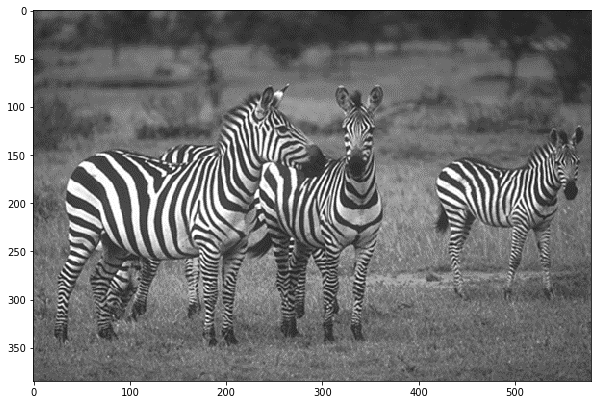

In [2]:
datadir='./data/'
im=np.float32(skio.imread(datadir+'/images_test/zebres.png'))
if len(im.shape)>2: # image couleur
    im=im.sum(axis=2)/3
plt.figure(figsize=(10,10))
plt.imshow(im, cmap='gray')

In [3]:
sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [78]:
denoiser_dct=DCT_denoiser()
sigma=25
imb=im+sigma*np.random.randn(*im.shape)
out_dct=denoiser_dct.do_denoise(imb,3*sigma,sess)
#mask=denoiser_dct.get_mask(im.shape) # ce mask ne depend que de la taille de l'image
#out_dct=out_dct/mask

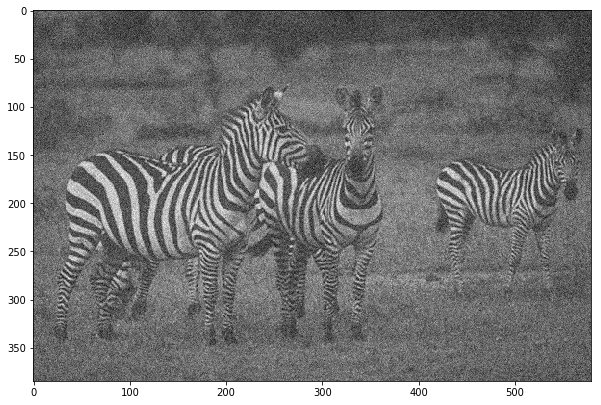

In [79]:
plt.figure(figsize=(10,10))
plt.imshow(imb, cmap='gray')

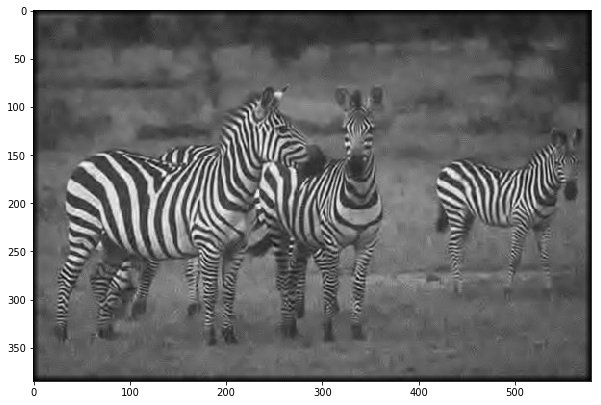

In [80]:
plt.figure(figsize=(10,10))
plt.imshow(out_dct, cmap='gray')

Some experiments to understand what $D$ is:

In [81]:
from scipy.fftpack import idct, idctn, dct, dctn
N=7
A=np.zeros((N,N,N**2))  
for k in range(N):
	for m in range(N):
		A[k,m,k+m*N]=1.0

O=idct(A,type=2,axis=0,norm='ortho')
D=idct(O,type=2,axis=1,norm='ortho')
DD = D.reshape((N,N,1,N*N))

In [43]:
D[:,:,2]

array([[ 0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,
         0.1820232 ,  0.1820232 ],
       [ 0.04495602,  0.04495602,  0.04495602,  0.04495602,  0.04495602,
         0.04495602,  0.04495602],
       [-0.12596396, -0.12596396, -0.12596396, -0.12596396, -0.12596396,
        -0.12596396, -0.12596396],
       [-0.20203051, -0.20203051, -0.20203051, -0.20203051, -0.20203051,
        -0.20203051, -0.20203051],
       [-0.12596396, -0.12596396, -0.12596396, -0.12596396, -0.12596396,
        -0.12596396, -0.12596396],
       [ 0.04495602,  0.04495602,  0.04495602,  0.04495602,  0.04495602,
         0.04495602,  0.04495602],
       [ 0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,
         0.1820232 ,  0.1820232 ]])

In [42]:
idctn(A[0,2].reshape(7,7), type=2, norm='ortho')

array([[ 0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,
         0.1820232 ,  0.1820232 ],
       [ 0.04495602,  0.04495602,  0.04495602,  0.04495602,  0.04495602,
         0.04495602,  0.04495602],
       [-0.12596396, -0.12596396, -0.12596396, -0.12596396, -0.12596396,
        -0.12596396, -0.12596396],
       [-0.20203051, -0.20203051, -0.20203051, -0.20203051, -0.20203051,
        -0.20203051, -0.20203051],
       [-0.12596396, -0.12596396, -0.12596396, -0.12596396, -0.12596396,
        -0.12596396, -0.12596396],
       [ 0.04495602,  0.04495602,  0.04495602,  0.04495602,  0.04495602,
         0.04495602,  0.04495602],
       [ 0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,
         0.1820232 ,  0.1820232 ]])

# DnCNN

In [8]:
modelsdir='./data/models/'

def lecture_poids_DnCNN():
    f=open(modelsdir+'/'+'model_DnCNN_25.pickle','br')
    poids,noms=pickle.load(f)
    f.close()
    return poids

def conv2d_with_bias_relu(inputs,W,B,name='NONAME'):
    conv=tf.nn.conv2d(inputs,W,strides=[1,1,1,1],padding="SAME")
    return tf.nn.relu(tf.add(conv,B),name=name)

def conv2d_with_bias(inputs,W,B,name='NONAME'):
    conv=tf.nn.conv2d(inputs,W,strides=[1,1,1,1],padding="SAME")
    return tf.add(conv,B,name=name)

def conv2d_with_normalization_relu(inputs,W,mean,sig,gamma,beta,name='NONAME'):
    conv=tf.nn.conv2d(inputs,W,strides=[1,1,1,1],padding="SAME")-mean
    conv=tf.add(tf.multiply(tf.divide(conv,(sig)),gamma),beta)
    return tf.nn.relu(conv,name=name)

def tfc(X):
    return tf.constant(X,dtype=tf.float32)

class DnCNN():
    def __init__(self,poids):
        self.noise=25
        self.X=tf.placeholder(tf.float32, [None, None, None, 1],
                                 name='noisy_image')
        inputs=self.X
        self.H=[inputs]
        self.block1=conv2d_with_bias_relu(inputs,tfc(poids[0]),tfc(poids[1]))
        inputs=self.block1
        self.H.append(inputs)
        for k in range(15):
            inputs=conv2d_with_normalization_relu(inputs,tfc(poids[5*k+2]),tfc(poids[5*k+5]),
                                                  tfc(poids[5*k+6]**0.5),tfc(poids[5*k+3]),tfc(poids[5*k+4]),name=('block%d'%k))
            self.H.append(inputs)
        self.H.append(conv2d_with_bias(inputs,tfc(poids[-2]),tfc(poids[-1])))
        self.Y=self.X-self.H[-1]
            
    def do_denoise(self,image,sess,add_noise=False):
        if add_noise:
            imageb=image+np.random.randn(*image.shape)*self.noise
        else:
            imageb=image
        [out]=sess.run([self.Y],feed_dict={self.X:imageb.reshape((1,*image.shape,1))/255.0})
        return 255*(out[0].reshape(image.shape))
    
    def do_denoise_batch(self,images,sess,add_noise=False):
        if add_noise:
            imageb=images+np.random.randn(*images.shape)*self.noise
        else:
            imageb=images
        [out]=sess.run([self.Y],feed_dict={self.X:images/255.0})
        return 255*out[0]


In [82]:
poids=lecture_poids_DnCNN()
denoiser_dncnn=DnCNN(poids)
out_dncnn=denoiser_dncnn.do_denoise(imb,sess)

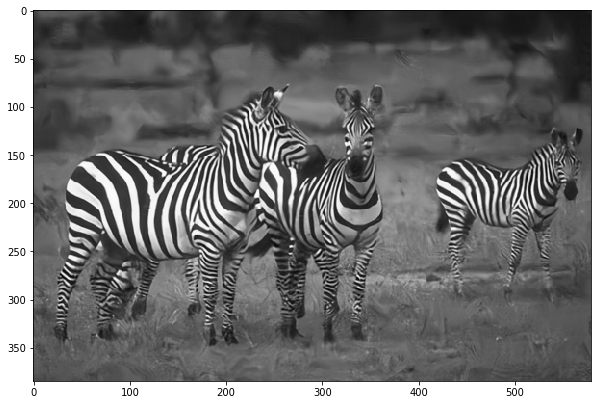

In [83]:
plt.figure(figsize=(10,10))
plt.imshow(out_dncnn, cmap='gray')

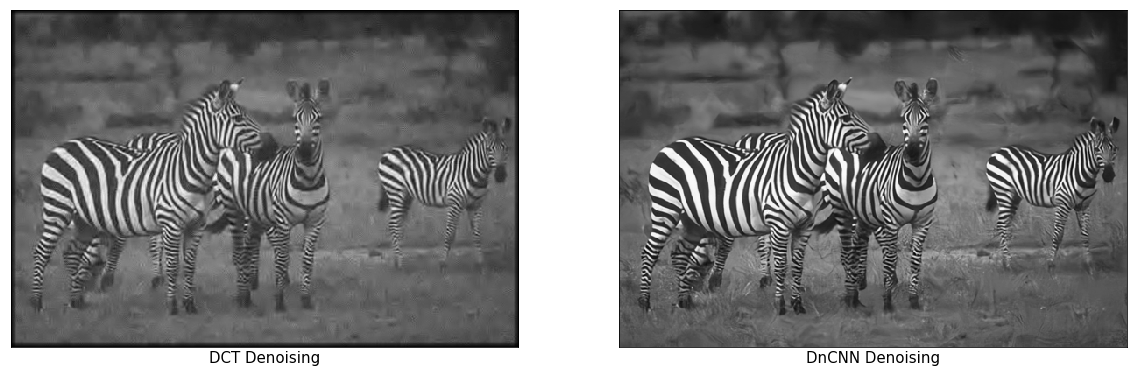

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].imshow(out_dct, cmap='gray')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel("DCT Denoising", fontsize=15)
ax[1].imshow(out_dncnn, cmap='gray')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel("DnCNN Denoising", fontsize=15)
plt.savefig('plot.eps', bbox_inches='tight')
plt.show()

In [43]:
ax

array([<matplotlib.axes._subplots.AxesSubplot object at 0x14781d2e8>,
      dtype=object)

In [13]:
3*3*1*64 + 64 + (16-2+1)*(3*3*64*64+64) + 3*3*64*1+1

555137

In [14]:
64*3*3 + 15*64*64*3*3 + 64*3*3

554112

In [31]:
denoiser_dncnn.H

[<tf.Tensor 'noisy_image:0' shape=(?, ?, ?, 1) dtype=float32>,
 <tf.Tensor 'NONAME:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block0:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block1:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block2:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block3:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block4:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block5:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block6:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block7:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block8:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block9:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block10:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block11:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block12:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block13:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block14:0' shape=(?, ?, ?, 64) dtyp

In [32]:
with sess.as_default():
    test = denoiser_dncnn.H[1].eval(feed_dict = {denoiser_dncnn.X:imb.reshape((1,*imb.shape,1))})

In [33]:
test.shape

(1, 385, 580, 64)